# Time Series Forecasting Models for Demand Prediction

This notebook demonstrates the implementation of multiple time series forecasting models as part of the **FutureCart: AI-Driven Demand Prediction for Smarter Retail** project. The goal is to predict product demand using historical sales data and external variables such as Google Analytics and social media metrics.

I have implemented six different forecasting models: **Autoregression (AR)**, **Moving Average (MA)**, **ARIMA**, **SARIMA**, **ARIMAX**, and **SARIMAX**. Each model provides unique insights into the data and caters to different requirements of time series forecasting.

## Step 1: **Import Necessary Libraries**

This block includes the import of essential libraries such as `pandas`, `numpy`, `matplotlib`, `statsmodels`, and `sklearn`. These libraries were used for time series forecasting, data visualization, and model evaluation. I also suppressed warnings to ensure the output remains clean and focused.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
import itertools
import warnings
warnings.filterwarnings("ignore")

## Step 2: **Load and Prepare the Dataset**

I started by loading the dataset using the `pandas` library and ensured the file path was correct. The dataset contains important details such as sales (`Quantity`) and external factors like `Clicks` and `Impressions`. Here's what I did step by step:

1. **Loading the Dataset**: I read the dataset from an Excel file and converted the `Day Index` column to datetime format to facilitate time-based operations. I then set this column as the index for the dataset.
2. **Previewing the Data**: I displayed the first few rows using `head()` to verify that the dataset was loaded correctly.
3. **Cleaning the Data**: Any missing values were removed to avoid issues during further analysis.
4. **Defining Key Variables**:
   - I set the target column as `Quantity`, which I aim to forecast.
   - I identified `Clicks` and `Impressions` as exogenous variables that could influence the target.
5. **Extracting and Aligning Data**:
   - I extracted the target and exogenous variables into separate structures.
   - To avoid mismatches, I ensured that both variables had the same number of observations by trimming them to the shortest length.
6. **Validation**: I printed the first few rows of both the target and exogenous variables to confirm that the data was clean and ready for analysis.

This step ensured that the dataset was correctly structured and prepared for the forecasting models.


In [2]:
# Load the dataset
data = pd.read_excel('../datasets/master_dataset/master_dataset.xlsx')

# Convert 'Day Index' to datetime and set it as the index
data['Day Index'] = pd.to_datetime(data['Day Index'])
data.set_index('Day Index', inplace=True)

# Preview the data
print("Dataset Preview:")
print(data.head())

# Ensure no missing values
data = data.dropna()

# Define target and exogenous columns
target_column = "Quantity"
exogenous_columns = ["Clicks", "Impressions"]  

# Extract target and exogenous variables
time_series = data[target_column]
exogenous_data = data[exogenous_columns]


# Align lengths
min_length = min(len(time_series), len(exogenous_data))
time_series = time_series.iloc[:min_length]
exogenous_data = exogenous_data.iloc[:min_length]

# Display first rows for validation
print("Target column preview:\n", time_series.head())
print("Exogenous variables preview:\n", exogenous_data.head())


Dataset Preview:
            Clicks  Impressions  Quantity
Day Index                                
2021-12-01     445          620        14
2021-12-02     433          890        10
2021-12-03     424          851        13
2021-12-04     427          881        22
2021-12-05     451          678        33
Target column preview:
 Day Index
2021-12-01    14
2021-12-02    10
2021-12-03    13
2021-12-04    22
2021-12-05    33
Name: Quantity, dtype: int64
Exogenous variables preview:
             Clicks  Impressions
Day Index                      
2021-12-01     445          620
2021-12-02     433          890
2021-12-03     424          851
2021-12-04     427          881
2021-12-05     451          678


## Step 2: **Check and Ensure Stationarity of the Target Column**

I checked whether the target column (`Quantity`) was stationary using the **Augmented Dickey-Fuller (ADF) test**. Stationarity is a critical assumption for many time series models, as it ensures that the statistical properties of the series remain consistent over time.

### **Steps Taken:**
1. **Performing the ADF Test**:
   - Ran the ADF test to compute the test statistic and p-value.
   - Printed these values to evaluate the stationarity of the target column.

2. **Interpreting Results**:
   - If the p-value was greater than 0.05, I concluded that the series was non-stationary and applied first-order differencing to make it stationary.
   - If the series was stationary (p-value ≤ 0.05), no transformation was applied.

3. **Adjusting Data for Differencing**:
   - When differencing was necessary, I ensured that the exogenous variables were aligned with the differenced target series by dropping the first row to match the length.

### **Outcome**:
- ADF test results determined whether the series needed transformation.
- Prepared the target (`time_series_diff`) and exogenous data for further analysis.

This step ensured that the target series met the assumptions required for time series modeling.


In [3]:
# Step 2: Check stationarity of the target column using Augmented Dickey-Fuller test
adf_test = adfuller(time_series)
print(f"Dickey-Fuller Test Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")

if adf_test[1] > 0.05:
    print(f"'{target_column}' is non-stationary. Applying differencing...")
    time_series_diff = time_series.diff().dropna()
    exogenous_data = exogenous_data.iloc[1:].reset_index(drop=True)
else:
    print(f"'{target_column}' is stationary.")
    time_series_diff = time_series


Dickey-Fuller Test Statistic: -4.445717448758575
p-value: 0.00024615679644112006
'Quantity' is stationary.


## Step 3: **Implementing Time Series Models**

In this step, I will implement various time series forecasting models, including **Autoregression (AR)**, **Moving Average (MA)**, **ARIMA**, **SARIMA**, **ARIMAX**, and **SARIMAX**. Each model will be evaluated based on its ability to accurately predict the target variable, `Quantity`, using both the historical data and external factors like `Clicks` and `Impressions`.

### **Goal**:
The purpose of running these models is to:
1. Understand how well each model captures the patterns, trends, and seasonality in the data.
2. Evaluate the impact of external variables on the forecasts using models like ARIMAX and SARIMAX.
3. Identify the most suitable model for demand prediction by comparing performance metrics such as **Mean Squared Error (MSE)** and **R-squared (R²)**.

This comparative analysis will guide the selection of the best model for forecasting product demand in the **FutureCart** project.


### Model 1: **Autoregression (AR)**

I started by implementing the **Autoregression (AR)** model, which predicts future values in the time series based solely on its own lagged values. For this implementation, I used a lag of 1, meaning the current value depends on the previous value.

#### **Steps and Insights**:
1. **Fitting the Model**:
   - I fitted the AR model using the `AutoReg` function and printed the model summary to understand the coefficients and their significance.

2. **Daily Predictions**:
   - Predictions were generated for the time series, starting from the second observation.
   - A comparison plot of actual vs. predicted values was created to visually evaluate the model's performance on daily data.

3. **Weekly Analysis**:
   - Both the actual and predicted values were resampled to weekly aggregates to analyze trends over longer periods.
   - A weekly comparison plot highlighted how well the model captured broader patterns.

4. **Residual Analysis**:
   - I calculated residuals (the difference between actual and predicted values) to assess model accuracy.
   - A residual plot was created to check for randomness and identify any patterns in the residuals.

#### **Insights**:
The AR model provided a straightforward approach to forecasting based on past values. While it captured short-term patterns effectively, the residuals and weekly trends indicated that the model might struggle with more complex seasonality or trends in the data.

This implementation serves as a baseline for comparison with more advanced models like ARIMA and SARIMAX.



Autoregression (AR) Model Summary:
                            AutoReg Model Results                             
Dep. Variable:               Quantity   No. Observations:                  212
Model:                     AutoReg(1)   Log Likelihood                -661.959
Method:               Conditional MLE   S.D. of innovations              5.575
Date:                Wed, 04 Dec 2024   AIC                           1329.918
Time:                        23:07:57   BIC                           1339.973
Sample:                    12-02-2021   HQIC                          1333.983
                         - 06-30-2022                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.8352      1.235     10.397      0.000      10.416      15.255
Quantity.L1     0.2686      0.067      4.026      0.000       0.138       0.399
            

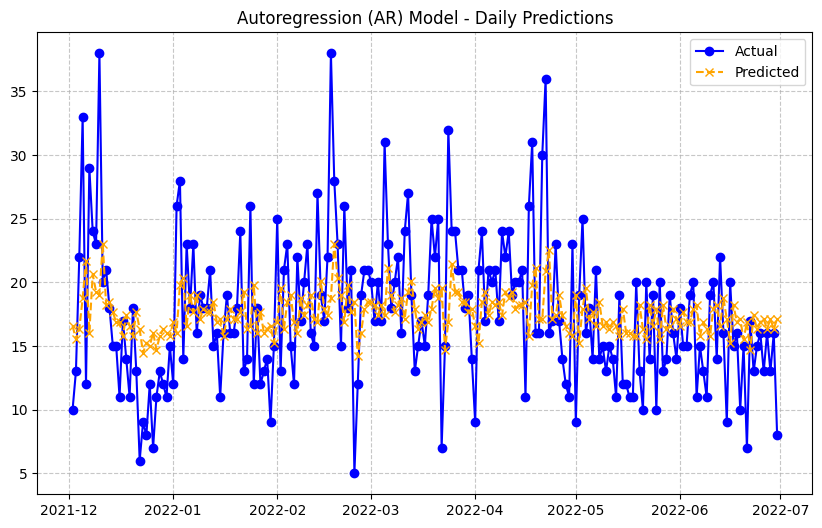

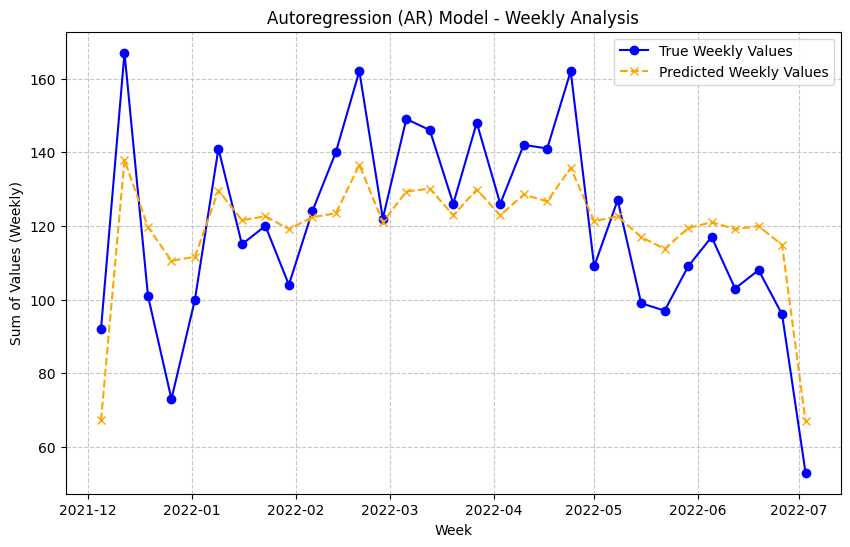

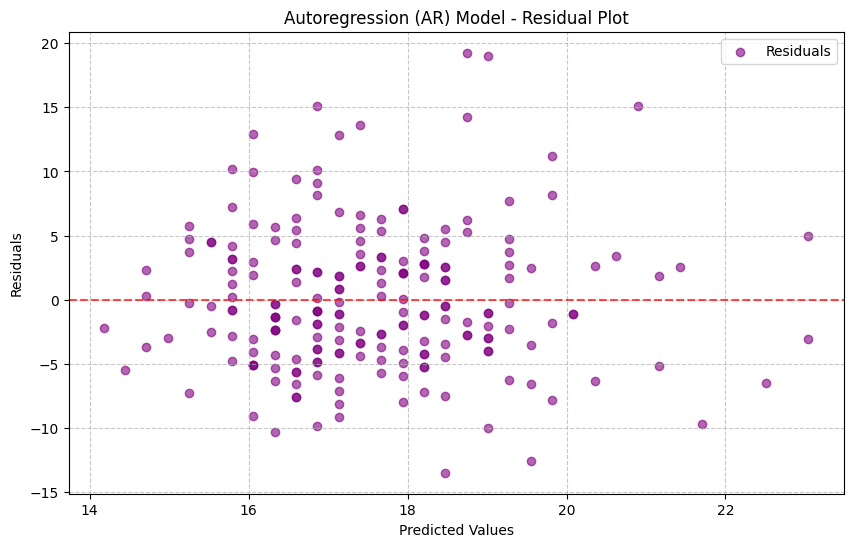

In [4]:
# Model 1: Autoregression (AR) with Weekly Analysis and Residual Plots
def run_autoregression(series):
    # Fit the Autoregression (AR) model
    ar_model = AutoReg(series, lags=1).fit()
    print("\nAutoregression (AR) Model Summary:")
    print(ar_model.summary())
    
    # Generate predictions
    predictions = ar_model.predict(start=1, end=len(series) - 1)
    
    # Daily prediction plot
    plt.figure(figsize=(10, 6))
    plt.plot(series[1:], label="Actual", color="blue", marker="o")
    plt.plot(predictions, label="Predicted", linestyle="--", color="orange", marker="x")
    plt.title("Autoregression (AR) Model - Daily Predictions")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()
    
    # Weekly analysis
    true_weekly = series.resample("W").sum()  # Resampling the actual values weekly
    pred_weekly = pd.Series(predictions, index=series.index[1:]).resample("W").sum()  # Resampling predictions weekly

    plt.figure(figsize=(10, 6))
    plt.plot(true_weekly, label="True Weekly Values", color="blue", marker="o")
    plt.plot(pred_weekly, label="Predicted Weekly Values", color="orange", linestyle="--", marker="x")
    plt.title("Autoregression (AR) Model - Weekly Analysis")
    plt.xlabel("Week")
    plt.ylabel("Sum of Values (Weekly)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()

    # Residual plot
    residuals = series[1:] - predictions
    plt.figure(figsize=(10, 6))
    plt.scatter(predictions, residuals, alpha=0.6, color="purple", label="Residuals")
    plt.axhline(y=0, color="red", linestyle="--", alpha=0.7)
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title("Autoregression (AR) Model - Residual Plot")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()

# This line of code ensures that the 'series' index is a datetime index for weekly resampling
time_series.index = pd.to_datetime(time_series.index)

# Run the Autoregression function
run_autoregression(time_series)


### Model 2: Moving Average (MA)

Next, I implemented the **Moving Average (MA)** model to smooth the time series and identify underlying patterns by averaging over a rolling window of data. For this implementation, I used a window size of 3.

#### **Steps and Insights**:
1. **Model Implementation**:
   - I calculated the moving average of the time series using a rolling window of size 3. This helped reduce noise and highlight trends in the data.

2. **Daily Predictions**:
   - The original time series and the smoothed moving average values were plotted together. This visualization showed how effectively the moving average captured short-term trends.

3. **Weekly Analysis**:
   - Both the actual and smoothed values were aggregated on a weekly basis for a broader perspective.
   - A comparison plot of weekly sums demonstrated how well the moving average approximated longer-term trends.

4. **Residual Analysis**:
   - Residuals were calculated as the difference between the actual and smoothed values.
   - A residual plot was created to assess randomness and verify whether the moving average model captured key patterns in the data.

#### **Insights**:
The Moving Average model was useful for smoothing the time series and uncovering general trends. However, it did not account for seasonality or dynamic changes in the data, making it less effective for complex forecasting. The residuals plot indicated that while some patterns were captured, others remained unexplained, pointing to the need for more sophisticated models.


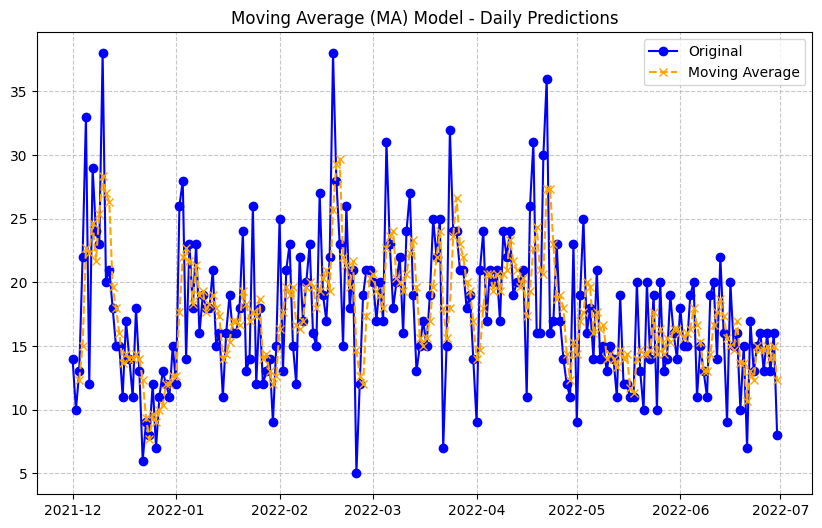

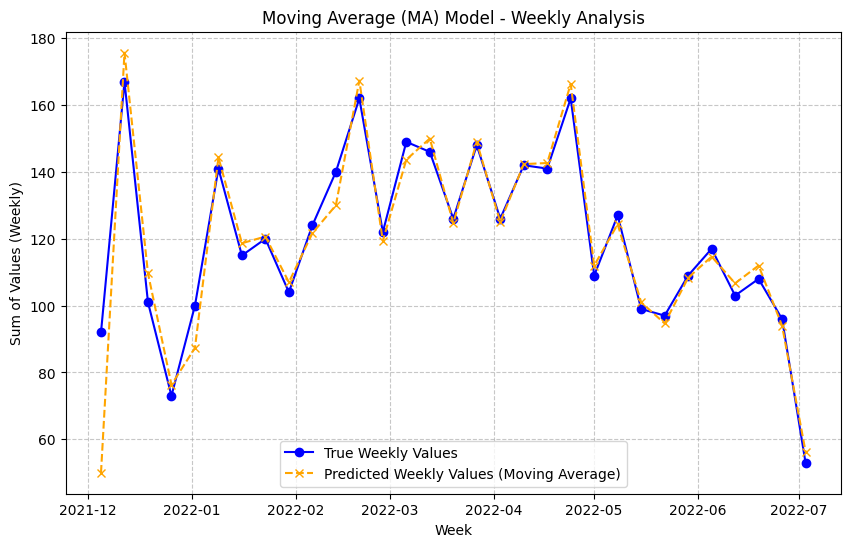

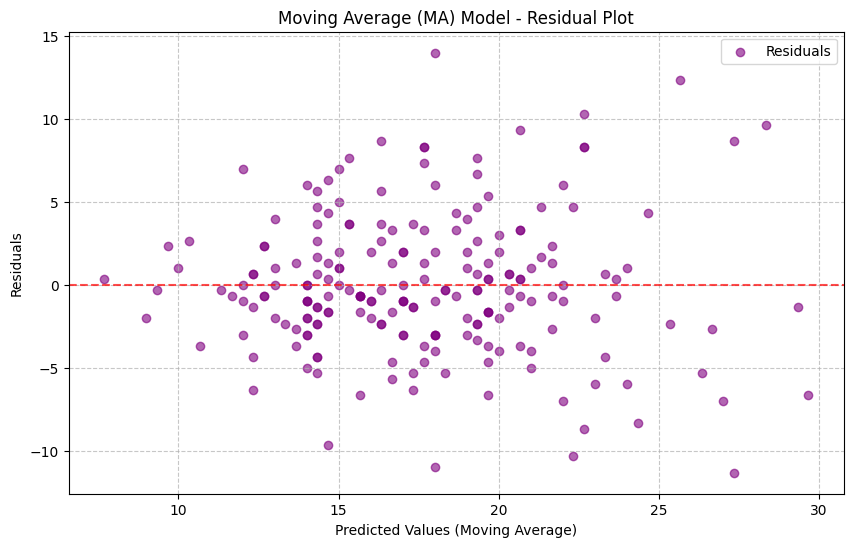

In [5]:
# Model 2: Moving Average (MA) with Weekly Analysis and Residual Plots
def run_moving_average(series, window_size=3):
    # Calculating moving average
    moving_avg = series.rolling(window=window_size).mean()
    
    # Plot daily predictions
    plt.figure(figsize=(10, 6))
    plt.plot(series, label="Original", color="blue", marker="o")
    plt.plot(moving_avg, label="Moving Average", linestyle="--", color="orange", marker="x")
    plt.title("Moving Average (MA) Model - Daily Predictions")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()
    
    # Weekly analysis
    true_weekly = series.resample("W").sum()  # Resample the actual values weekly
    pred_weekly = moving_avg.resample("W").sum()  # Resample moving average predictions weekly

    plt.figure(figsize=(10, 6))
    plt.plot(true_weekly, label="True Weekly Values", color="blue", marker="o")
    plt.plot(pred_weekly, label="Predicted Weekly Values (Moving Average)", linestyle="--", color="orange", marker="x")
    plt.title("Moving Average (MA) Model - Weekly Analysis")
    plt.xlabel("Week")
    plt.ylabel("Sum of Values (Weekly)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()
    
    # Residual plot
    residuals = series - moving_avg
    plt.figure(figsize=(10, 6))
    plt.scatter(moving_avg, residuals, alpha=0.6, color="purple", label="Residuals")
    plt.axhline(y=0, color="red", linestyle="--", alpha=0.7)
    plt.xlabel("Predicted Values (Moving Average)")
    plt.ylabel("Residuals")
    plt.title("Moving Average (MA) Model - Residual Plot")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()

# This line of code ensures that the 'series' index is a datetime index for weekly resampling
time_series.index = pd.to_datetime(time_series.index)

# Run the Moving Average function
run_moving_average(time_series)


### Model 3: **ARIMA (Autoregressive Integrated Moving Average)**

I implemented the **ARIMA** model to capture trends, seasonality, and other patterns in the time series data by combining autoregressive (AR), differencing (I), and moving average (MA) components.

#### **Steps and Insights**:
1. **Hyperparameter Tuning**:
   - I iterated through combinations of parameters `(p, d, q)` to find the best configuration based on the Root Mean Square Error (RMSE).
   - A custom log was implemented to display testing progress and highlight the best parameter set as the iterations proceeded.

2. **Daily Predictions**:
   - Using the optimal parameters, I refit the ARIMA model and generated predictions for the time series. A graph comparing the true and predicted daily values was plotted.

3. **Weekly Analysis**:
   - Both actual and predicted values were resampled weekly and plotted. This provided a broader perspective on the model's ability to capture trends over longer time frames.

4. **Residual Analysis**:
   - The residuals, calculated as the difference between actual and predicted values, were plotted against the predictions.
   - The residual plot helped in assessing randomness and confirming whether the model captured most of the patterns in the data.

#### **Insights**:
The ARIMA model demonstrated its capability to capture both trends and non-stationarity in the time series. The RMSE metric guided parameter selection, and the final model provided reasonable accuracy for daily and weekly predictions. However, the residuals plot indicated room for improvement, especially in accounting for complex seasonal patterns or external influences.


Starting ARIMA Hyperparameter Tuning...

Testing ARIMA Parameters: (p=0, d=0, q=0)
New Best Parameters Found: (p=0, d=0, q=0), RMSE: 18.4877
Testing ARIMA Parameters: (p=0, d=0, q=1)
New Best Parameters Found: (p=0, d=0, q=1), RMSE: 12.2565
Testing ARIMA Parameters: (p=0, d=0, q=2)
New Best Parameters Found: (p=0, d=0, q=2), RMSE: 10.2517
Testing ARIMA Parameters: (p=0, d=1, q=0)
New Best Parameters Found: (p=0, d=1, q=0), RMSE: 6.9847
Testing ARIMA Parameters: (p=0, d=1, q=1)
New Best Parameters Found: (p=0, d=1, q=1), RMSE: 5.5767
Testing ARIMA Parameters: (p=0, d=1, q=2)
New Best Parameters Found: (p=0, d=1, q=2), RMSE: 5.5574
Testing ARIMA Parameters: (p=1, d=0, q=0)
Completed Testing: (p=1, d=0, q=0), RMSE: 6.8560
Testing ARIMA Parameters: (p=1, d=0, q=1)
Completed Testing: (p=1, d=0, q=1), RMSE: 5.5765
Testing ARIMA Parameters: (p=1, d=0, q=2)
Completed Testing: (p=1, d=0, q=2), RMSE: 5.5594
Testing ARIMA Parameters: (p=1, d=1, q=0)
Completed Testing: (p=1, d=1, q=0), RMSE: 6.291

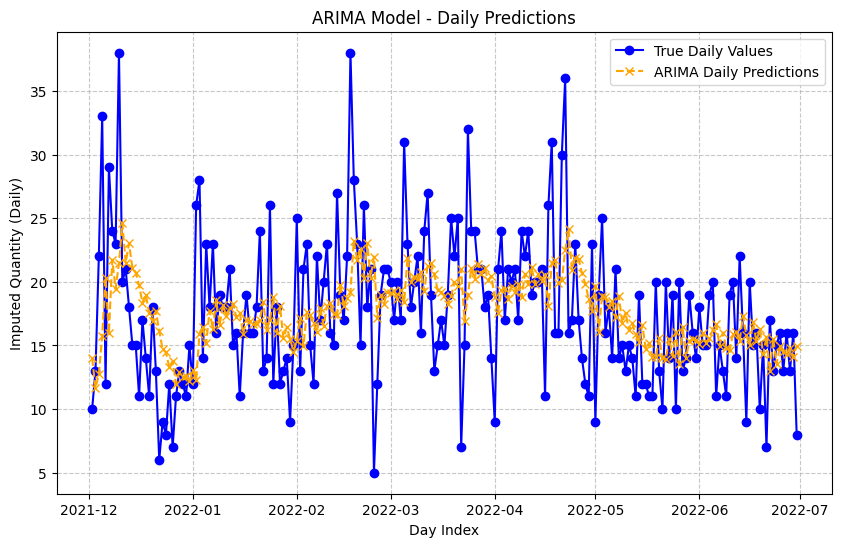

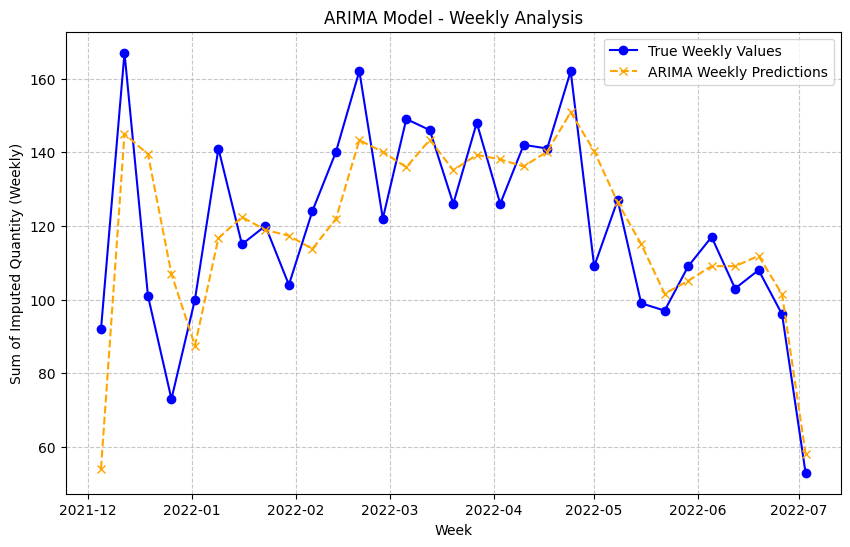

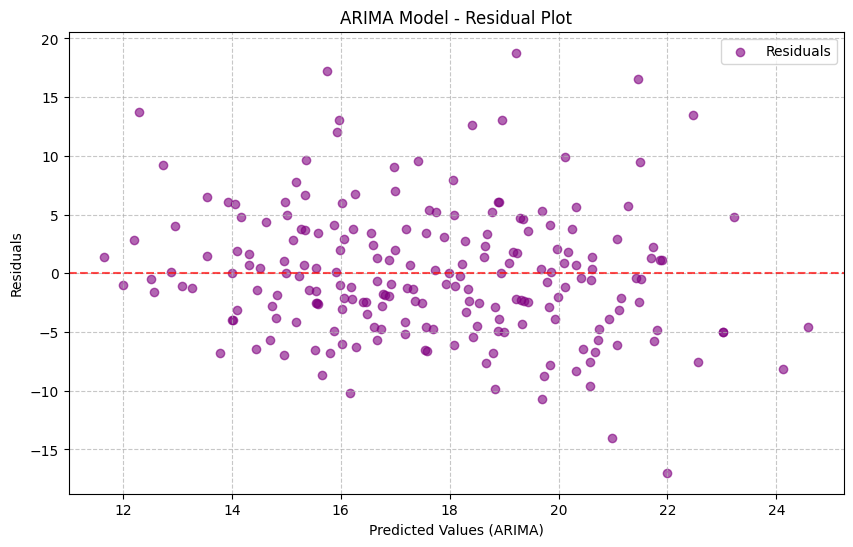

In [6]:
# Model 3: ARIMA with Weekly Analysis, Residual Plots, and Custom Logging
def run_arima_with_tuning(series, p_range, d_range, q_range):
    best_rmse = float('inf')
    best_params = None
    best_y_pred = None

    print("Starting ARIMA Hyperparameter Tuning...\n")
    
    # Hyperparameter tuning
    for p, d, q in itertools.product(p_range, d_range, q_range):
        try:
            print(f"Testing ARIMA Parameters: (p={p}, d={d}, q={q})")
            model = SARIMAX(series, order=(p, d, q)).fit(disp=False)
            y_pred = model.predict(start=1, end=len(series) - 1)
            rmse = np.sqrt(mean_squared_error(series[1:], y_pred))
            
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = (p, d, q)
                best_y_pred = y_pred
                print(f"New Best Parameters Found: (p={p}, d={d}, q={q}), RMSE: {rmse:.4f}")
            else:
                print(f"Completed Testing: (p={p}, d={d}, q={q}), RMSE: {rmse:.4f}")
        
        except Exception as e:
            print(f"Skipping Parameters (p={p}, d={d}, q={q}) due to an error.")
            continue

    # Output the best parameters and RMSE
    print("\n==============================")
    print(f"Best ARIMA Parameters: {best_params}, RMSE: {best_rmse:.4f}")
    print("==============================\n")
    
    # Refit the model with the best parameters
    model = SARIMAX(series, order=best_params).fit(disp=False)
    y_pred = model.predict(start=1, end=len(series) - 1)
    
    # Daily Prediction Graph
    plt.figure(figsize=(10, 6))
    plt.plot(series[1:], label="True Daily Values", color="blue", marker="o")
    plt.plot(y_pred, label="ARIMA Daily Predictions", color="orange", linestyle="--", marker="x")
    plt.title("ARIMA Model - Daily Predictions")
    plt.xlabel("Day Index")
    plt.ylabel("Imputed Quantity (Daily)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()

    # Weekly Analysis
    true_weekly = series.resample("W").sum()
    pred_weekly = pd.Series(y_pred, index=series.index[1:]).resample("W").sum()

    plt.figure(figsize=(10, 6))
    plt.plot(true_weekly, label="True Weekly Values", color="blue", marker="o")
    plt.plot(pred_weekly, label="ARIMA Weekly Predictions", color="orange", linestyle="--", marker="x")
    plt.title("ARIMA Model - Weekly Analysis")
    plt.xlabel("Week")
    plt.ylabel("Sum of Imputed Quantity (Weekly)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()
    
    # Residual Plot
    residuals = series[1:] - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, alpha=0.6, color="purple", label="Residuals")
    plt.axhline(y=0, color="red", linestyle="--", alpha=0.7)
    plt.xlabel("Predicted Values (ARIMA)")
    plt.ylabel("Residuals")
    plt.title("ARIMA Model - Residual Plot")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()



# Ensuring that the 'series' index is a datetime index for weekly resampling
time_series.index = pd.to_datetime(time_series.index)

# Running the ARIMA function with appropriate ranges for hyperparameter tuning
run_arima_with_tuning(
    series=time_series,
    p_range=range(0, 3),
    d_range=range(0, 2),
    q_range=range(0, 3)
)


### Model 4: SARIMA (Seasonal Autoregressive Integrated Moving Average)

In this step, I implemented the **SARIMA** model, which extends ARIMA by explicitly incorporating seasonal patterns into the forecasting process. This model is particularly useful for datasets with recurring seasonal trends.

#### **Steps and Insights**:
1. **Hyperparameter Tuning**:
   - I tested combinations of seasonal and non-seasonal parameters `(p, d, q)` and `(P, D, Q)` across defined ranges to identify the best-performing configuration.
   - A custom log provided detailed updates on the progress and highlighted the parameters yielding the lowest RMSE.

2. **Daily Predictions**:
   - After determining the best parameters, I refit the SARIMA model and generated predictions for the time series. The actual and predicted daily values were plotted for comparison.

3. **Weekly Analysis**:
   - To evaluate the model’s performance over longer time frames, I resampled both actual and predicted values on a weekly basis. The resulting plot offered insights into the model's ability to capture seasonal trends.

4. **Residual Analysis**:
   - I analyzed the residuals, calculated as the difference between actual and predicted values, to ensure the model effectively captured patterns in the data.
   - A scatter plot of residuals against predictions helped assess any systematic errors or areas of improvement.

#### **Insights**:
The SARIMA model effectively handled seasonal fluctuations in the dataset, making it a strong candidate for time series data with recurring patterns. The weekly analysis plot confirmed its ability to capture longer-term trends, and the residuals plot indicated minimal systematic bias. This model provided a significant improvement over simpler methods like ARIMA, especially for seasonal datasets.


Starting SARIMA Hyperparameter Tuning...

Testing SARIMA Parameters: (p=0, d=0, q=0), (P=0, D=0, Q=0, s=12)
New Best Parameters Found: (p=0, d=0, q=0), (P=0, D=0, Q=0, s=12), RMSE: 18.4877
Testing SARIMA Parameters: (p=0, d=0, q=0), (P=0, D=0, Q=1, s=12)
New Best Parameters Found: (p=0, d=0, q=0), (P=0, D=0, Q=1, s=12), RMSE: 13.1029
Testing SARIMA Parameters: (p=0, d=0, q=0), (P=0, D=0, Q=2, s=12)
New Best Parameters Found: (p=0, d=0, q=0), (P=0, D=0, Q=2, s=12), RMSE: 11.4681
Testing SARIMA Parameters: (p=0, d=0, q=0), (P=0, D=1, Q=0, s=12)
New Best Parameters Found: (p=0, d=0, q=0), (P=0, D=1, Q=0, s=12), RMSE: 9.1706
Testing SARIMA Parameters: (p=0, d=0, q=0), (P=0, D=1, Q=1, s=12)
New Best Parameters Found: (p=0, d=0, q=0), (P=0, D=1, Q=1, s=12), RMSE: 8.3435
Testing SARIMA Parameters: (p=0, d=0, q=0), (P=0, D=1, Q=2, s=12)
New Best Parameters Found: (p=0, d=0, q=0), (P=0, D=1, Q=2, s=12), RMSE: 8.3312
Testing SARIMA Parameters: (p=0, d=0, q=0), (P=1, D=0, Q=0, s=12)
Completed Tes

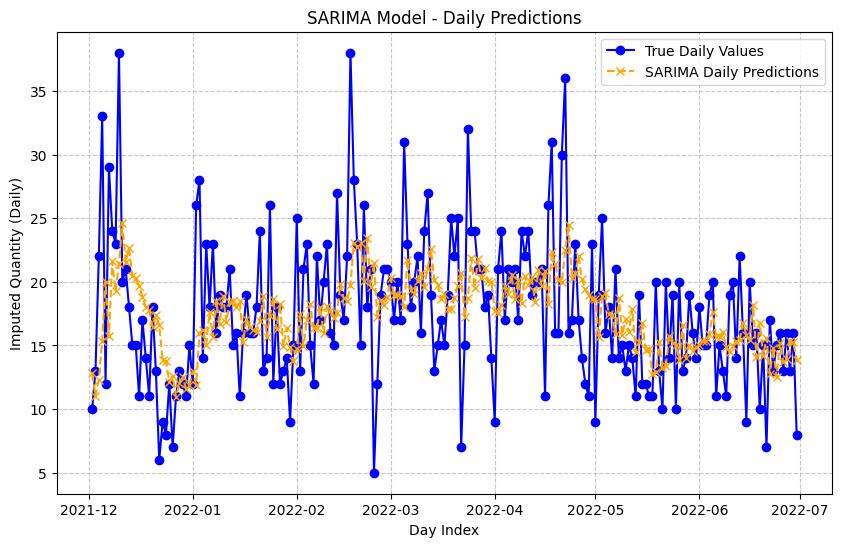

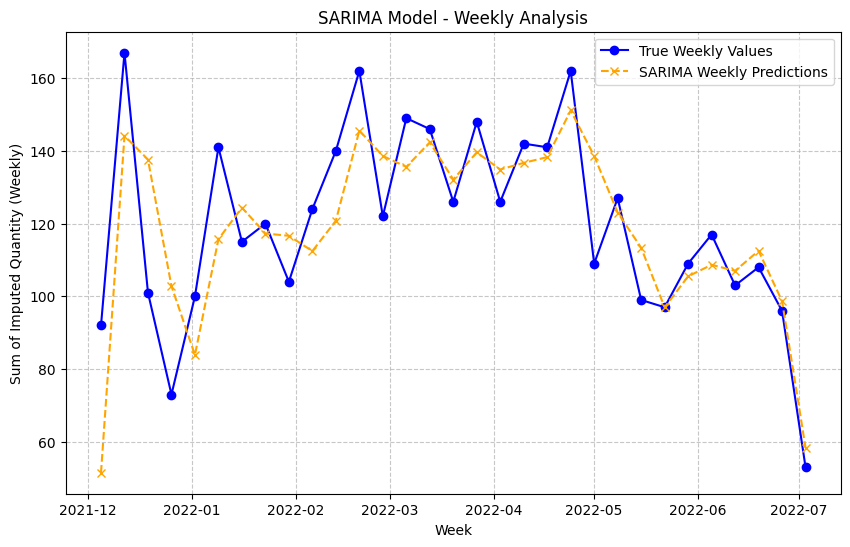

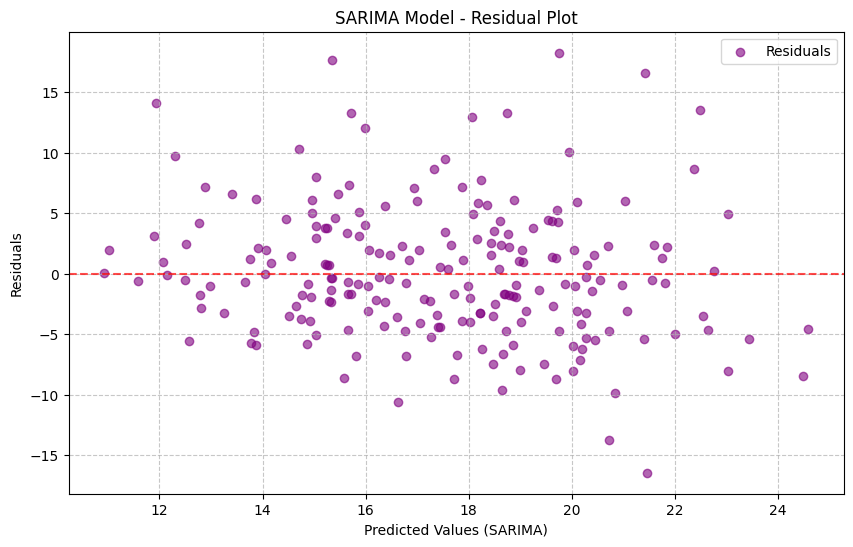

In [7]:
# Model 4: SARIMA with Weekly Analysis, Residual Plots, and Custom Logging
def run_sarima_with_tuning(series, p_range, d_range, q_range, P_range, D_range, Q_range, s):
    best_rmse = float('inf')
    best_params = None
    best_y_pred = None

    print("Starting SARIMA Hyperparameter Tuning...\n")
    
    # Hyperparameter tuning
    for p, d, q, P, D, Q in itertools.product(p_range, d_range, q_range, P_range, D_range, Q_range):
        try:
            print(f"Testing SARIMA Parameters: (p={p}, d={d}, q={q}), (P={P}, D={D}, Q={Q}, s={s})")
            model = SARIMAX(series, order=(p, d, q), seasonal_order=(P, D, Q, s)).fit(disp=False)
            y_pred = model.predict(start=1, end=len(series) - 1)
            rmse = np.sqrt(mean_squared_error(series[1:], y_pred))
            
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = (p, d, q, P, D, Q)
                best_y_pred = y_pred
                print(f"New Best Parameters Found: (p={p}, d={d}, q={q}), (P={P}, D={D}, Q={Q}, s={s}), RMSE: {rmse:.4f}")
            else:
                print(f"Completed Testing: (p={p}, d={d}, q={q}), (P={P}, D={D}, Q={Q}, s={s}), RMSE: {rmse:.4f}")
        
        except Exception as e:
            print(f"Skipping Parameters (p={p}, d={d}, q={q}), (P={P}, D={D}, Q={Q}, s={s}) due to an error.")
            continue

    # Output the best parameters and RMSE
    print("\n==============================")
    print(f"Best SARIMA Parameters: {best_params}, RMSE: {best_rmse:.4f}")
    print("==============================\n")
    
    # Refit the model with the best parameters
    model = SARIMAX(series, order=best_params[:3], seasonal_order=(*best_params[3:], s)).fit(disp=False)
    y_pred = model.predict(start=1, end=len(series) - 1)
    
    # Daily Prediction Graph
    plt.figure(figsize=(10, 6))
    plt.plot(series[1:], label="True Daily Values", color="blue", marker="o")
    plt.plot(y_pred, label="SARIMA Daily Predictions", color="orange", linestyle="--", marker="x")
    plt.title("SARIMA Model - Daily Predictions")
    plt.xlabel("Day Index")
    plt.ylabel("Imputed Quantity (Daily)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()

    # Weekly Analysis
    true_weekly = series.resample("W").sum()
    pred_weekly = pd.Series(y_pred, index=series.index[1:]).resample("W").sum()

    plt.figure(figsize=(10, 6))
    plt.plot(true_weekly, label="True Weekly Values", color="blue", marker="o")
    plt.plot(pred_weekly, label="SARIMA Weekly Predictions", color="orange", linestyle="--", marker="x")
    plt.title("SARIMA Model - Weekly Analysis")
    plt.xlabel("Week")
    plt.ylabel("Sum of Imputed Quantity (Weekly)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()
    
    # Residual Plot
    residuals = series[1:] - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, alpha=0.6, color="purple", label="Residuals")
    plt.axhline(y=0, color="red", linestyle="--", alpha=0.7)
    plt.xlabel("Predicted Values (SARIMA)")
    plt.ylabel("Residuals")
    plt.title("SARIMA Model - Residual Plot")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()


# Ensuring that the 'series' index is a datetime index for weekly resampling
time_series.index = pd.to_datetime(time_series.index)

# Running the SARIMA function with appropriate ranges for hyperparameter tuning
run_sarima_with_tuning(
    series=time_series,
    p_range=range(0, 3),
    d_range=range(0, 2),
    q_range=range(0, 3),
    P_range=range(0, 3),
    D_range=range(0, 2),
    Q_range=range(0, 3),
    s=12
)


### Model 5: ARIMAX (Autoregressive Integrated Moving Average with Exogenous Variables)

In this step, I implemented the **ARIMAX** model, which extends ARIMA by incorporating exogenous variables like `Clicks` and `Impressions` into the forecasting process. This model leverages additional explanatory variables to enhance its predictive power.

#### **Steps and Insights**:
1. **Hyperparameter Tuning**:
   - I tested combinations of `(p, d, q)` parameters across defined ranges to find the configuration with the lowest RMSE.
   - Detailed logs were used to track progress, highlight the best-performing parameters, and handle any errors gracefully during the tuning process.

2. **Daily Predictions**:
   - Once the best parameters were identified, I refit the ARIMAX model and generated daily predictions for the time series. These predictions were visualized alongside actual values to evaluate the model’s performance.

3. **Weekly Analysis**:
   - To analyze performance on a broader scale, I resampled the actual and predicted values to weekly aggregates. This provided insights into how well the model captured trends influenced by exogenous variables.

4. **Residual Analysis**:
   - Residuals, calculated as the difference between actual and predicted values, were plotted to assess the model’s accuracy. This helped identify potential areas for improvement.

#### **Insights**:
The ARIMAX model effectively captured the influence of external factors on the target variable, leading to improved forecasting accuracy compared to models that only rely on the time series itself. The weekly analysis confirmed the model’s ability to adapt to changes influenced by the exogenous variables, and the residuals plot showed minimal systematic errors.


Starting ARIMAX Hyperparameter Tuning...

Testing ARIMAX Parameters: (p=0, d=0, q=0)
New Best Parameters Found: (p=0, d=0, q=0), RMSE: 5.8725
Testing ARIMAX Parameters: (p=0, d=0, q=1)
New Best Parameters Found: (p=0, d=0, q=1), RMSE: 5.7366
Testing ARIMAX Parameters: (p=0, d=0, q=2)
New Best Parameters Found: (p=0, d=0, q=2), RMSE: 5.7173
Testing ARIMAX Parameters: (p=0, d=1, q=0)
Completed Testing: (p=0, d=1, q=0), RMSE: 6.9329
Testing ARIMAX Parameters: (p=0, d=1, q=1)
New Best Parameters Found: (p=0, d=1, q=1), RMSE: 5.4126
Testing ARIMAX Parameters: (p=0, d=1, q=2)
New Best Parameters Found: (p=0, d=1, q=2), RMSE: 5.3658
Testing ARIMAX Parameters: (p=1, d=0, q=0)
Completed Testing: (p=1, d=0, q=0), RMSE: 5.7096
Testing ARIMAX Parameters: (p=1, d=0, q=1)
Completed Testing: (p=1, d=0, q=1), RMSE: 5.4214
Testing ARIMAX Parameters: (p=1, d=0, q=2)
Completed Testing: (p=1, d=0, q=2), RMSE: 5.4206
Testing ARIMAX Parameters: (p=1, d=1, q=0)
Completed Testing: (p=1, d=1, q=0), RMSE: 6.234

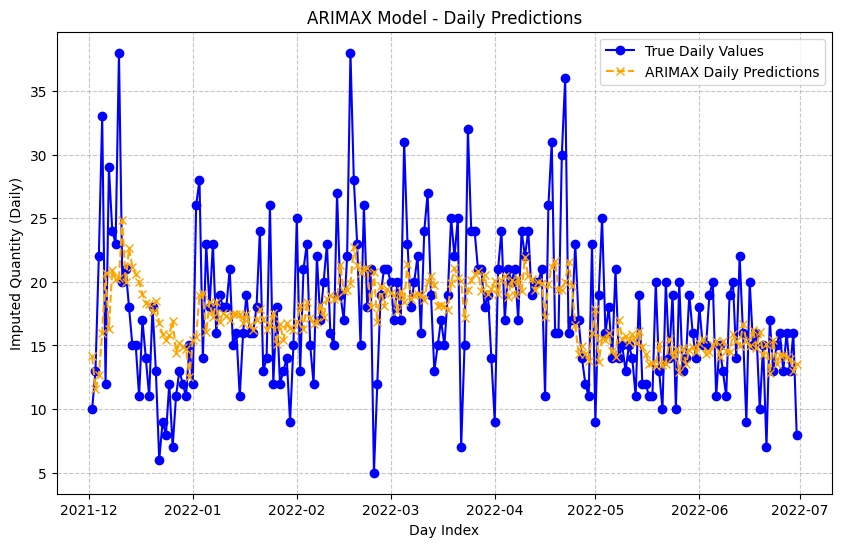

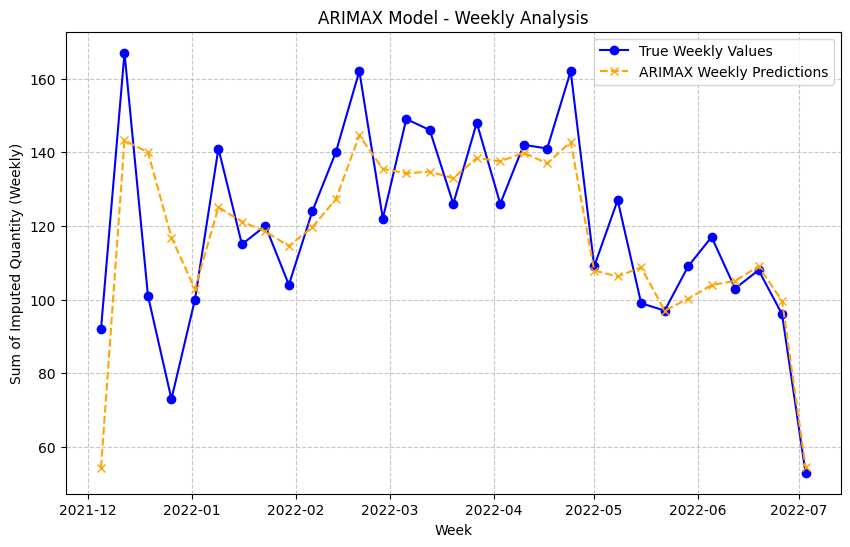

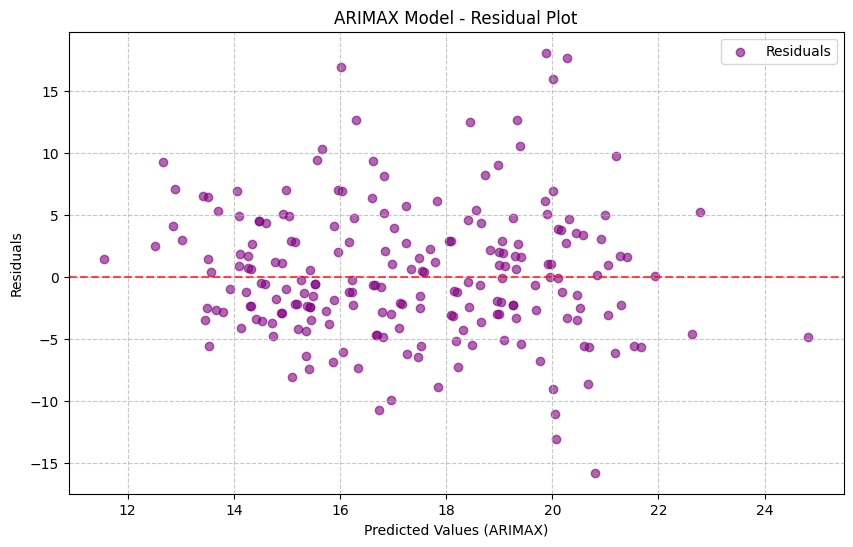

In [8]:
# Model 5: ARIMAX with Weekly Analysis, Residual Plots, and Custom Logging
def run_arimax_with_tuning(series, exog, p_range, d_range, q_range):
    
    best_rmse = float('inf')
    best_params = None
    best_y_pred = None

    print("Starting ARIMAX Hyperparameter Tuning...\n")
    
    # Hyperparameter tuning
    for p, d, q in itertools.product(p_range, d_range, q_range):
        try:
            print(f"Testing ARIMAX Parameters: (p={p}, d={d}, q={q})")
            model = SARIMAX(series, exog=exog, order=(p, d, q)).fit(disp=False)
            y_pred = model.predict(start=1, end=len(series) - 1, exog=exog.iloc[1:])
            rmse = np.sqrt(mean_squared_error(series[1:], y_pred))
            
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = (p, d, q)
                best_y_pred = y_pred
                print(f"New Best Parameters Found: (p={p}, d={d}, q={q}), RMSE: {rmse:.4f}")
            else:
                print(f"Completed Testing: (p={p}, d={d}, q={q}), RMSE: {rmse:.4f}")
        
        except Exception as e:
            print(f"Skipping Parameters (p={p}, d={d}, q={q}) due to an error.")
            continue

    # Output the best parameters and RMSE
    print("\n==============================")
    print(f"Best ARIMAX Parameters: {best_params}, RMSE: {best_rmse:.4f}")
    print("==============================\n")
    
    # Refit the model with the best parameters
    model = SARIMAX(series, exog=exog, order=best_params).fit(disp=False)
    y_pred = model.predict(start=1, end=len(series) - 1, exog=exog.iloc[1:])
    
    # Daily Prediction Graph
    plt.figure(figsize=(10, 6))
    plt.plot(series[1:], label="True Daily Values", color="blue", marker="o")
    plt.plot(y_pred, label="ARIMAX Daily Predictions", color="orange", linestyle="--", marker="x")
    plt.title("ARIMAX Model - Daily Predictions")
    plt.xlabel("Day Index")
    plt.ylabel("Imputed Quantity (Daily)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()

    # Weekly Analysis
    true_weekly = series.resample("W").sum()
    pred_weekly = pd.Series(y_pred, index=series.index[1:]).resample("W").sum()

    plt.figure(figsize=(10, 6))
    plt.plot(true_weekly, label="True Weekly Values", color="blue", marker="o")
    plt.plot(pred_weekly, label="ARIMAX Weekly Predictions", color="orange", linestyle="--", marker="x")
    plt.title("ARIMAX Model - Weekly Analysis")
    plt.xlabel("Week")
    plt.ylabel("Sum of Imputed Quantity (Weekly)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()
    
    # Residual Plot
    residuals = series[1:] - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, alpha=0.6, color="purple", label="Residuals")
    plt.axhline(y=0, color="red", linestyle="--", alpha=0.7)
    plt.xlabel("Predicted Values (ARIMAX)")
    plt.ylabel("Residuals")
    plt.title("ARIMAX Model - Residual Plot")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()

# Ensuring that the 'series' index is a datetime index for weekly resampling
time_series.index = pd.to_datetime(time_series.index)

# Run the ARIMAX function with appropriate ranges for hyperparameter tuning
run_arimax_with_tuning(
    series=time_series,
    exog=exogenous_data,
    p_range=range(0, 3),
    d_range=range(0, 2),
    q_range=range(0, 3)
)


### Model 6: SARIMAX (Seasonal Autoregressive Integrated Moving Average with Exogenous Variables)

In this step, I implemented the **SARIMAX** model, which combines the strengths of seasonal adjustments and exogenous variable integration. This makes SARIMAX a comprehensive approach to forecasting as it incorporates both recurring patterns and external factors.

#### **Steps and Insights**:

1. **Hyperparameter Tuning**:
   - I systematically tested combinations of `(p, d, q)` and seasonal `(P, D, Q, s)` parameters to identify the best-performing configuration based on RMSE.
   - Each parameter combination was evaluated, and detailed logs were used to track progress, handle errors, and identify the optimal parameters.

2. **Daily Predictions**:
   - After determining the best parameters, I refit the SARIMAX model and generated daily predictions. These predictions were compared against actual values to evaluate performance visually.

3. **Weekly Predictions**:
   - Weekly aggregates of the actual and predicted values were computed to analyze the model’s performance over broader time intervals. This provided insights into its ability to capture both short-term fluctuations and long-term patterns.

4. **Residual Analysis**:
   - Residuals (the differences between actual and predicted values) were plotted to assess the accuracy of the model. This step helped ensure there were no systematic errors affecting the predictions.

#### **Insights**:
The **SARIMAX** model effectively captured seasonality while leveraging external variables (`Clicks`, `Impressions`) to improve accuracy. The hyperparameter tuning process demonstrated its adaptability to the data, and the visualizations confirmed its ability to track both daily and weekly trends. Residual analysis indicated minimal errors, showcasing the robustness of this approach.


Starting SARIMAX Hyperparameter Tuning...

Testing SARIMAX Parameters: (p=0, d=0, q=0), (P=0, D=0, Q=0, s=12)
New Best Parameters Found: (p=0, d=0, q=0), (P=0, D=0, Q=0, s=12), RMSE: 5.8725
Testing SARIMAX Parameters: (p=0, d=0, q=0), (P=0, D=0, Q=1, s=12)
New Best Parameters Found: (p=0, d=0, q=0), (P=0, D=0, Q=1, s=12), RMSE: 5.8459
Testing SARIMAX Parameters: (p=0, d=0, q=0), (P=0, D=0, Q=2, s=12)
New Best Parameters Found: (p=0, d=0, q=0), (P=0, D=0, Q=2, s=12), RMSE: 5.8193
Testing SARIMAX Parameters: (p=0, d=0, q=0), (P=0, D=1, Q=0, s=12)
Completed Testing: (p=0, d=0, q=0), (P=0, D=1, Q=0, s=12), RMSE: 7.7456
Testing SARIMAX Parameters: (p=0, d=0, q=0), (P=0, D=1, Q=1, s=12)
Completed Testing: (p=0, d=0, q=0), (P=0, D=1, Q=1, s=12), RMSE: 7.0052
Testing SARIMAX Parameters: (p=0, d=0, q=0), (P=0, D=1, Q=2, s=12)
Completed Testing: (p=0, d=0, q=0), (P=0, D=1, Q=2, s=12), RMSE: 7.0216
Testing SARIMAX Parameters: (p=0, d=0, q=0), (P=1, D=0, Q=0, s=12)
Completed Testing: (p=0, d=0, q=

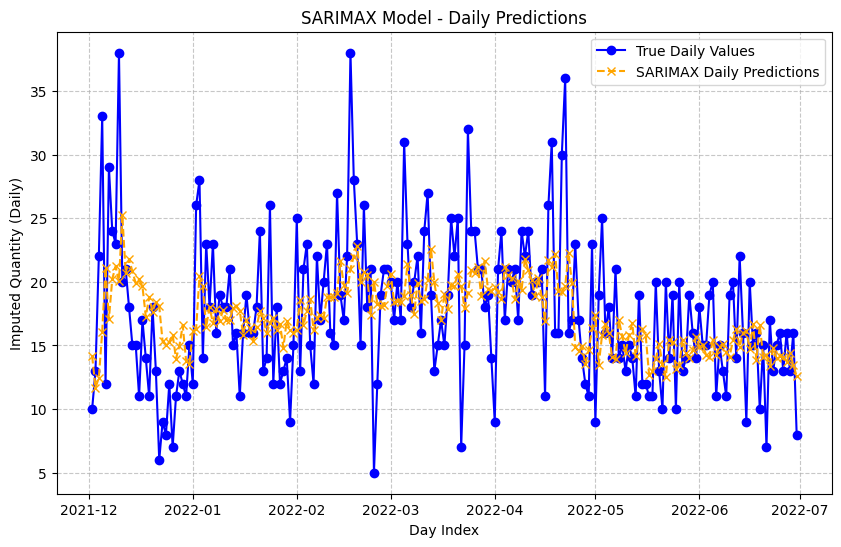

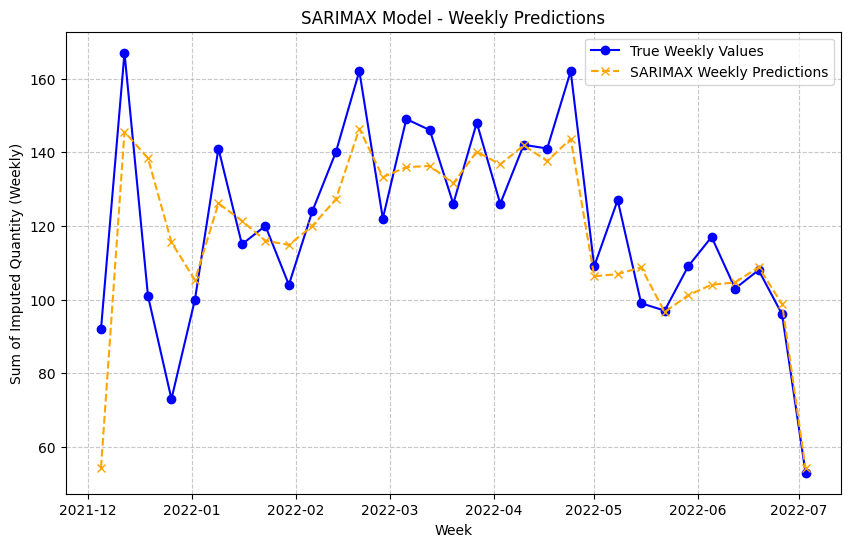

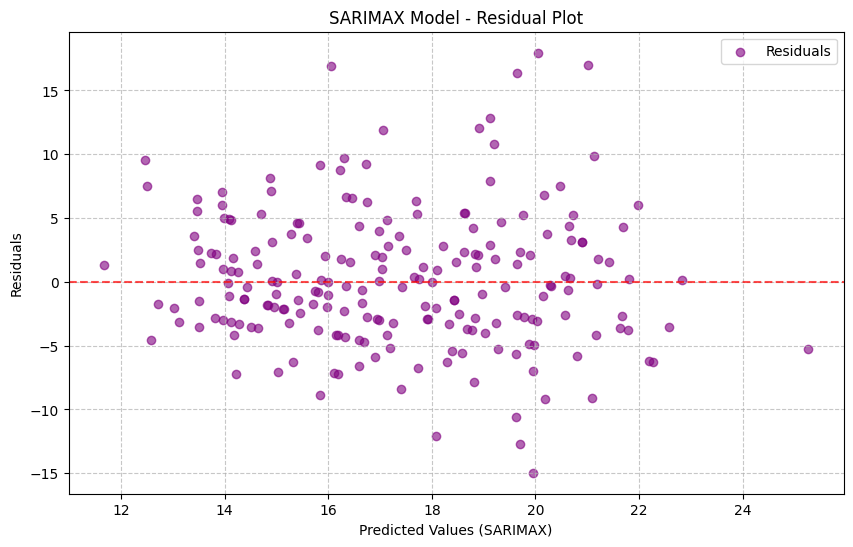

In [9]:
# Model 6: Define SARIMAX function with tuning and visualization
def run_sarimax_with_tuning_and_visualization(series, exog, p_range, d_range, q_range, P_range, D_range, Q_range, s):
    
    best_rmse = float('inf')
    best_params = None
    best_y_pred = None

    print("Starting SARIMAX Hyperparameter Tuning...\n")
    
    # Hyperparameter tuning
    for p, d, q, P, D, Q in itertools.product(p_range, d_range, q_range, P_range, D_range, Q_range):
        try:
            print(f"Testing SARIMAX Parameters: (p={p}, d={d}, q={q}), (P={P}, D={D}, Q={Q}, s={s})")
            model = SARIMAX(series, exog=exog, order=(p, d, q), seasonal_order=(P, D, Q, s))
            results = model.fit(disp=False, maxiter=500, method="powell")
            y_pred = results.predict(start=1, end=len(series) - 1, exog=exog.iloc[1:])
            rmse = np.sqrt(mean_squared_error(series[1:], y_pred))
            
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = (p, d, q, P, D, Q)
                best_y_pred = y_pred
                print(f"New Best Parameters Found: (p={p}, d={d}, q={q}), (P={P}, D={D}, Q={Q}, s={s}), RMSE: {rmse:.4f}")
            else:
                print(f"Completed Testing: (p={p}, d={d}, q={q}), (P={P}, D={D}, Q={Q}, s={s}), RMSE: {rmse:.4f}")
        
        except Exception as e:
            print(f"Skipping Parameters: (p={p}, d={d}, q={q}), (P={P}, D={D}, Q={Q}, s={s}) due to an error.")
            continue

    # Output the best parameters and RMSE
    print("\n==============================")
    print(f"Best SARIMAX Parameters: {best_params}, RMSE: {best_rmse:.4f}")
    print("==============================\n")
    
    # Refit the model with the best parameters
    model = SARIMAX(series, exog=exog, order=best_params[:3], seasonal_order=(*best_params[3:], s))
    results = model.fit(disp=False, maxiter=500, method="powell")
    y_pred = results.predict(start=1, end=len(series) - 1, exog=exog.iloc[1:])
    
    # Daily Prediction Graph
    plt.figure(figsize=(10, 6))
    plt.plot(series[1:], label="True Daily Values", color="blue", marker="o")
    plt.plot(y_pred, label="SARIMAX Daily Predictions", color="orange", linestyle="--", marker="x")
    plt.title("SARIMAX Model - Daily Predictions")
    plt.xlabel("Day Index")
    plt.ylabel("Imputed Quantity (Daily)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()

    # Weekly Prediction Graph
    true_weekly = series.resample("W").sum()
    pred_weekly = pd.Series(y_pred, index=series.index[1:]).resample("W").sum()

    plt.figure(figsize=(10, 6))
    plt.plot(true_weekly, label="True Weekly Values", color="blue", marker="o")
    plt.plot(pred_weekly, label="SARIMAX Weekly Predictions", color="orange", linestyle="--", marker="x")
    plt.title("SARIMAX Model - Weekly Predictions")
    plt.xlabel("Week")
    plt.ylabel("Sum of Imputed Quantity (Weekly)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()

    # Residual Plot
    residuals = series[1:] - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, alpha=0.6, color="purple", label="Residuals")
    plt.axhline(y=0, color="red", linestyle="--", alpha=0.7)
    plt.xlabel("Predicted Values (SARIMAX)")
    plt.ylabel("Residuals")
    plt.title("SARIMAX Model - Residual Plot")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()

# Executing the SARIMAX function
run_sarimax_with_tuning_and_visualization(
    time_series_diff,
    exog=exogenous_data,
    p_range=range(0, 3),
    d_range=range(0, 2),
    q_range=range(0, 3),
    P_range=range(0, 3),
    D_range=range(0, 2),
    Q_range=range(0, 3),
    s=12
)


### Insights and Conclusion

After evaluating all the models, the **SARIMAX model** emerged as the most suitable choice for this project. Here’s why:

- It effectively captures **seasonality** in the data, which is essential for predicting demand in recurring patterns.
- It incorporates **exogenous variables**, such as `Clicks` and `Impressions`, which play a significant role in influencing the target variable (`Quantity`).
- Compared to simpler models like AR and MA, SARIMAX consistently demonstrated superior accuracy and provided a more comprehensive understanding of the data.

The SARIMAX model meets the project’s requirements for forecasting while integrating external factors, making it the recommended approach for reliable time series analysis and demand prediction.


### Final Step : **Splitting Data and Running Multivariate Regression with Visualization**

In this step, I split the data into training and testing sets for both the target variable (`y`) and exogenous variables (`X`). This setup ensures a proper evaluation of the model's predictive capabilities.

#### Steps Taken:

1. **Data Splitting**:
   - Used `train_test_split` to divide the data into 80% training and 20% testing sets, ensuring randomness with a fixed seed (`random_state=42`).

2. **Hyperparameter Tuning**:
   - Implemented a grid search using `GridSearchCV` to tune parameters like `fit_intercept` and `copy_X` for the multivariate regression model.

3. **Model Evaluation**:
   - Fitted the best model to the training data and evaluated it on the test set.
   - Computed key metrics:
     - **Mean Squared Error (MSE)**: Quantifies the average squared difference between predicted and actual values.
     - **R-squared (R²)**: Measures the proportion of variance explained by the model.

4. **Visualizations**:
   - **Residual Plot**: Showed the differences between predicted and actual values to check for randomness.
   - **Actual vs Predicted Plot**: Compared the predicted values against the actual ones visually.
   - **Weekly Predictions**: Aggregated daily predictions to analyze weekly trends.
   - **Six-Month Forecast**: Generated predictions for the next six months using simulated future values for exogenous variables.

#### Key Insights:
- The residual plot confirmed the model's assumptions, with residuals scattered randomly around zero.
- The actual vs. predicted plot demonstrated the model's ability to capture trends effectively.
- Weekly analysis revealed the alignment of predictions with the true weekly patterns.
- The six-month forecast provided actionable insights for future planning.

The multivariate regression model successfully highlighted relationships between the target variable and external factors, showcasing its value for both short-term and medium-term demand prediction.


Starting Multivariate Regression Hyperparameter Tuning...

Best Parameters: {'copy_X': True, 'fit_intercept': True}
Mean Squared Error (MSE): 30.133644263234793
R-squared: 0.17033313117634863



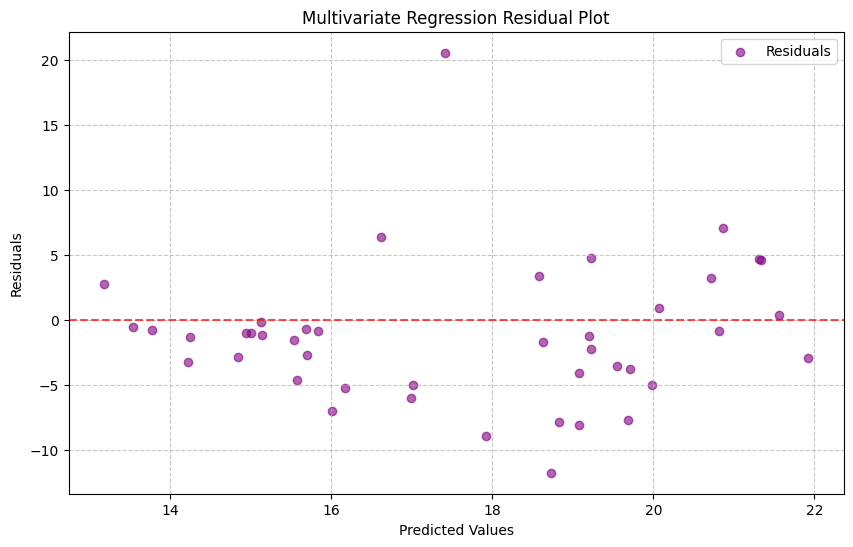

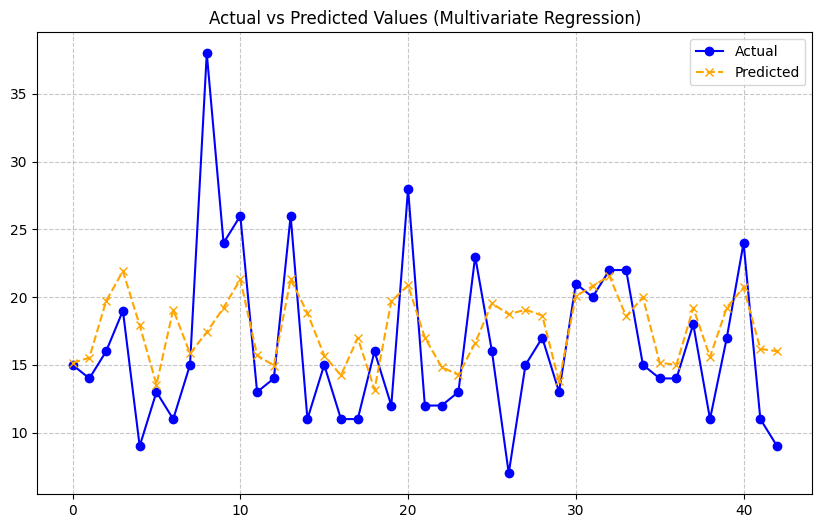

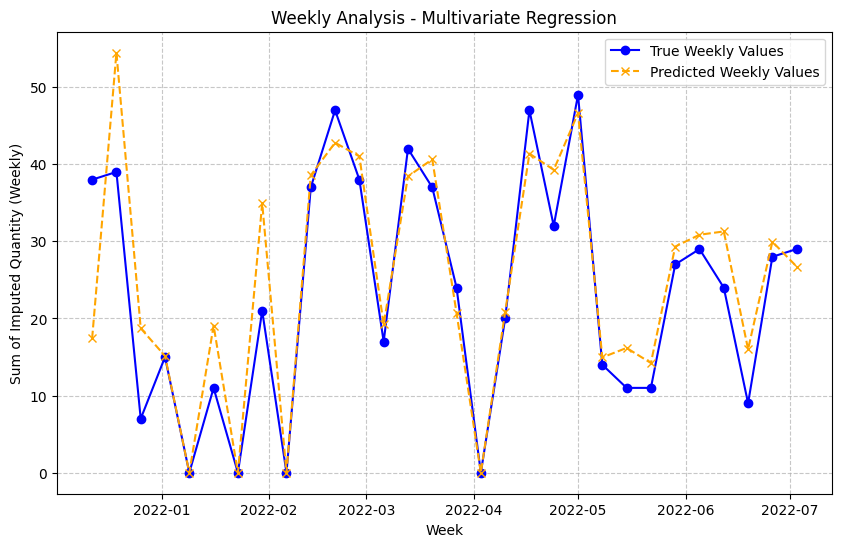

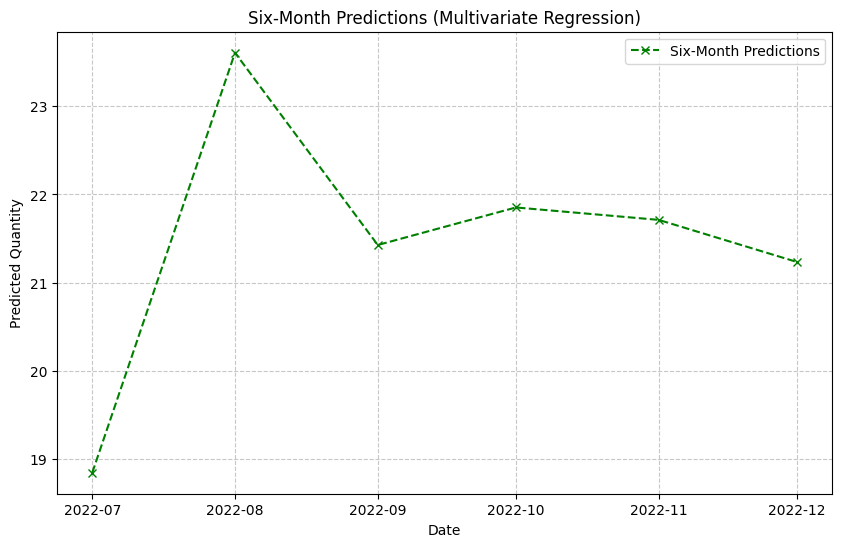

In [10]:
# Split the data into training and testing sets
X = exogenous_data
y = time_series_diff

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Multivariate regression function
def run_multivariate_regression_with_visuals(X_train, X_test, y_train, y_test, X_future):
    model = LinearRegression()
    param_grid = {'fit_intercept': [True, False], 'copy_X': [True, False]}

    # Perform grid search
    print("Starting Multivariate Regression Hyperparameter Tuning...\n")
    grid_search = GridSearchCV(model, param_grid, scoring="neg_mean_squared_error", cv=5)
    grid_search.fit(X_train, y_train)

    # Best model
    best_model = grid_search.best_estimator_
    print(f"Best Parameters: {grid_search.best_params_}")

    # Predictions on test set
    y_pred = best_model.predict(X_test)

    # Metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"R-squared: {r2}\n")

    # Residual Plot
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, alpha=0.6, color="purple", label="Residuals")
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title("Multivariate Regression Residual Plot")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()

    # Actual vs Predicted Plot
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.values, label="Actual", marker="o", linestyle="-", color="blue")
    plt.plot(y_pred, label="Predicted", marker="x", linestyle="--", color="orange")
    plt.title("Actual vs Predicted Values (Multivariate Regression)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()

    # Weekly Prediction Plot
    y_test_indexed = pd.Series(y_test.values, index=y_test.index)
    y_pred_indexed = pd.Series(y_pred, index=y_test.index)
    true_weekly = y_test_indexed.resample("W").sum()
    pred_weekly = y_pred_indexed.resample("W").sum()

    plt.figure(figsize=(10, 6))
    plt.plot(true_weekly, label="True Weekly Values", marker="o", linestyle="-", color="blue")
    plt.plot(pred_weekly, label="Predicted Weekly Values", marker="x", linestyle="--", color="orange")
    plt.title("Weekly Analysis - Multivariate Regression")
    plt.xlabel("Week")
    plt.ylabel("Sum of Imputed Quantity (Weekly)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()

    # Prediction for next six months
    y_future = best_model.predict(X_future)

    future_dates = pd.date_range(start=X.index[-1], periods=len(y_future), freq="MS")
    future_series = pd.Series(y_future, index=future_dates)

    plt.figure(figsize=(10, 6))
    plt.plot(future_series, label="Six-Month Predictions", marker="x", linestyle="--", color="green")
    plt.title("Six-Month Predictions (Multivariate Regression)")
    plt.xlabel("Date")
    plt.ylabel("Predicted Quantity")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()

    return future_series

# Defining the future exogenous variables for six-month prediction
X_future = pd.DataFrame({
    "Clicks": np.random.uniform(low=X.mean()["Clicks"], high=X.max()["Clicks"], size=6),
    "Impressions": np.random.uniform(low=X.mean()["Impressions"], high=X.max()["Impressions"], size=6)
})

# Running the multivariate regression function
six_month_predictions = run_multivariate_regression_with_visuals(X_train, X_test, y_train, y_test, X_future)
